In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
config = {
    "binary": True,
    "representations": "minilm",
    "load_precomputed": True, # lembrar de gerar usando 3 classes!
    "normalize": True,
    "seed": 1234
}

In [3]:
# Configurando seed
np.random.seed(config["seed"])

# Carregando dados de análise

In [4]:
train_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_train.csv", index_col=0)
test_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [5]:
train_df.head()

,label,text
5689,1,Simplesmente magnífica @fbbreal no Video Show ...
5386,1,"Saiu, mas saiu ahazando. Master Chef BR"
869,1,Já tô pronta pro Master Chef BR
5432,1,Muito amor por é o tchan Altas Horas
24,1,QUE PROGRAMA INCRÍVEL O @SBTTheNoite FEZ HOJE!...


# Conversão dos textos para representações densas

In [6]:
import spacy
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
nlp = spacy.load("pt_core_news_md")

In [7]:
from typing import Iterable

def convert_text_to_vector(text: str) -> Iterable[str]:

    tokens = nlp(text)

    text_vector = np.zeros(300)
    used_tokens = 0

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remoção simples de hashtags

        text_vector += token.vector
        used_tokens += 1
    
    return text_vector / used_tokens

In [8]:
# Gerando a representação densa desejada
if config["load_precomputed"]:
    load_path = "/home/kenzosaki/mestrado/data/tweetsentbr/sentence_bert_representations/" if config["representations"] == "bert" else \
                "/home/kenzosaki/mestrado/data/tweetsentbr/fast_text_representations/"
    print(f"- Loading precomputed representations from {load_path}.")
    X_train_raw = np.load(load_path + "train.npy")
    X_test_raw = np.load(load_path + "test.npy")
    
else:

    if config["representations"] == "bert":
        print("- Usando Sentence-Bert PT para representar os tweets")
        model = SentenceTransformer("/home/kenzosaki/mestrado/data/models/similarity_bertimbau", device="cuda")
        X_train_raw = model.encode(train_df["text"].values, show_progress_bar=True)
        X_test_raw = model.encode(test_df["text"].values, show_progress_bar=True)
        save_path = "/home/kenzosaki/mestrado/data/tweetsentbr/sentence_bert_representations/"

    elif config["representations"] == "minilm":
        print("- Usando mMiniLM para representar os tweets")
        model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", device="cuda")
        X_train_raw = model.encode(train_df["text"].values, show_progress_bar=True)
        X_test_raw = model.encode(test_df["text"].values, show_progress_bar=True)
        save_path = "/home/kenzosaki/mestrado/data/tweetsentbr/sentence_bert_representations/"    
    
    elif config["representations"] == "bert-multi":
        print("- Usando Sentence-Bert multilingual para representar os tweets")
        model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased", device="cuda")
        X_train_raw = model.encode(train_df["text"].values, show_progress_bar=True)
        X_test_raw = model.encode(test_df["text"].values, show_progress_bar=True)
        save_path = "/home/kenzosaki/mestrado/data/tweetsentbr/sentence_bert-multi_representations/"

    else:
        print("- Usando FastText Word Embeddings para representar os tweets")
        X_train_raw = [convert_text_to_vector(text) for text in train_df["text"]]
        X_test_raw = [convert_text_to_vector(text) for text in test_df["text"]]
        save_path = "/home/kenzosaki/mestrado/data/tweetsentbr/fast_text_representations/"

    # Serializando para evitar computar novamente
    np.save(save_path + "train", X_train_raw)
    np.save(save_path + "test", X_test_raw)


- Loading precomputed representations from /home/kenzosaki/mestrado/data/tweetsentbr/fast_text_representations/.


# Pre-processamento

In [9]:
# Para focar a análise em apenas duas classes: positivo e negativo
# Ajusta-se também os identificadores das classes para 0 -> positivo, 1 -> neutro
# Também é necessário filtrar representações a utilizar
if config["binary"]:
    keep_in_train = train_df["label"] != 0
    train_df = train_df[keep_in_train]
    train_df["label"] -= 1
    X_train_raw = X_train_raw[keep_in_train]

    keep_in_test = test_df["label"] != 0
    test_df = test_df[test_df["label"] != 0]
    test_df["label"] -= 1
    X_test_raw = X_test_raw[keep_in_test]

In [10]:
# Substituindo por zero exemplos inválidos (valores muito pequenos ou muito grandes)
X_train_raw = pd.DataFrame(X_train_raw).fillna(0).values
X_test_raw = pd.DataFrame(X_test_raw).fillna(0).values

In [11]:
# Preparando pares X, y
y_train = train_df["label"].values
y_test = test_df["label"].values

In [12]:
# Normalizando vetores
if config["normalize"]:
    print("- Aplicando normalização L2")
    X_train = normalize(X_train_raw)
    X_test = normalize(X_test_raw)
else:
    print("- Preservando valores originais")

- Aplicando normalização L2


# Preparando classificadores

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
models = {
    "MLP": MLPClassifier(max_iter=500, early_stopping=True),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVC": SVC(),
    # "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(n_estimators=100)
}

# Avaliando classificadores

In [15]:
from sklearn.metrics import classification_report
from tqdm import tqdm

In [16]:
def get_metrics(y_real, y_pred):

    metrics_dict = classification_report(y_real, y_pred, output_dict=True)

    return {
        "accuracy": metrics_dict["accuracy"],
        "precision": metrics_dict["macro avg"]["precision"],
        "recall": metrics_dict["macro avg"]["recall"],
        "f1": metrics_dict["macro avg"]["f1-score"]
    }


In [17]:
results_df = pd.DataFrame()

In [18]:
classes = "binary" if config["binary"] else "all_classes"
rep = config["representations"]

for model_name, model in tqdm(models.items(), desc="- Evaluating"):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_dict = get_metrics(y_test, y_pred)
    results_dict["model"] = model_name
    results_df = results_df.append(results_dict, ignore_index=True)

    preds_df = test_df.copy()
    preds_df["prediction"] = y_pred
    preds_df.to_csv(f"../data/predictions/{model_name}-{rep}_{classes}_preds.csv")

- Evaluating: 100%|██████████| 4/4 [00:17<00:00,  4.33s/it]


In [19]:
results_df

,accuracy,precision,recall,f1,model
0,0.774510,0.764436,0.762885,0.763624,MLP
1,0.714597,0.702776,0.686995,0.691137,KNN
2,0.776144,0.769484,0.755473,0.760374,SVC
3,0.741285,0.731426,0.718089,0.722390,RF


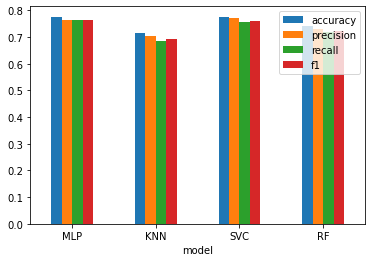

In [20]:
results_df.set_index("model").plot.bar(rot=0)